In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import burst_detector as bd
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from torch.profiler import profile, record_function, ProfilerActivity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
n_chan = 385

ks_dir = "../data/rec_bank0_dense_g0/KS2.5/catgt_rec_bank0_dense_g0/rec_bank0_dense_g0_imec0/imec0_ks2/"

times = np.load(os.path.join(ks_dir, "spike_times.npy")).flatten()
clusters = np.load(os.path.join(ks_dir, "spike_clusters.npy")).flatten()

counts = bd.spikes_per_cluster(clusters)
labels = pd.read_csv(os.path.join(ks_dir, "cluster_group.tsv"), sep="\t", index_col=False)
times_multi = bd.find_times_multi(times, clusters, np.arange(clusters.max()+1))

channel_pos = np.load(os.path.join(ks_dir, "channel_positions.npy"))
channel_map = np.load(os.path.join(ks_dir, "channel_map.npy")).flatten()
mean_wf = np.load(os.path.join(ks_dir, "mean_waveforms.npy"))
channel_shanks = (channel_pos[:,0]/250).astype("int")
templates = np.load(os.path.join(ks_dir, "templates.npy"))

# load raw data
rawData = np.memmap("C:/Users/Harris_Lab/Projects/burst-detector/data/rec_bank0_dense_g0/KS2.5/catgt_rec_bank0_dense_g0/rec_bank0_dense_g0_imec0/rec_bank0_dense_g0_tcat.imec0.ap.bin", dtype='int16', mode='r')
data = np.reshape(rawData, (int(rawData.size/n_chan), n_chan))

In [5]:
def get_closest_channels(channel_positions, channel_index, n=None):
    """Get the channels closest to a given channel on the probe."""
    x = channel_positions[:, 0]
    y = channel_positions[:, 1]
    x0, y0 = channel_positions[channel_index]
    d = (x - x0) ** 2 + (y - y0) ** 2
    out = np.argsort(d)
    if n:
        out = out[:n]
    return out

In [6]:
def find_best_channels(template):
    amplitude_threshold = 0
    
    amplitude = template.max(axis=1) - template.min(axis=1)
    best_channel = min(np.argmax(amplitude), 382)
    max_amp = amplitude[best_channel]
    
    peak_channels = np.nonzero(amplitude >= amplitude_threshold * max_amp)[0]
    
    close_channels = get_closest_channels(channel_pos, best_channel, 8)

    shank = channel_shanks[best_channel]
    channels_on_shank = np.nonzero(channel_shanks == shank)[0]
    close_channels = np.intersect1d(close_channels, channels_on_shank)
    channel_ids = np.intersect1d(close_channels, peak_channels)
    
    return channel_ids, best_channel

In [7]:
def get_dists(channel_positions, ref_chan, target_chan):
    x = channel_positions[:, 0]
    y = channel_positions[:, 1]
    x0, y0 = channel_positions[ref_chan]
    d = (x - x0) ** 2 + (y - y0) ** 2
    # d[y < y0] *= -1
    return d[target_chan]

In [8]:
chans = {}

for i in range(mean_wf.shape[0]):
    if i in counts:
        chs, peak = find_best_channels(mean_wf[i])
        dists = get_dists(channel_pos, peak, chs)
        chans[i] = chs[np.argsort(dists)].tolist()

In [9]:
chans_2 = {}

for i in range(383):
    chs = get_closest_channels(channel_pos, i, 8)
    dists = get_dists(channel_pos, i, chs)
    chans_2[i] = chs[np.argsort(dists)].tolist()

In [10]:
file_names = []
cl_ids = []

pre_samples = 15
post_samples = 35

max_spikes = 2000
min_spikes = 100


In [11]:
tot = 0
for i in range(clusters.max()+1):
    if (i in counts) and (counts[i] > min_spikes) and (labels.loc[labels['cluster_id']==i, 'group'].item() == 'good'):
        cl_times = times_multi[i].astype("int32")
        
        # cap number of spikes
        if (max_spikes < cl_times.shape[0]):
            np.random.shuffle(cl_times)
            cl_times = cl_times[:max_spikes]
            
        # save spikes to file and add to annotations
        for j in range(cl_times.shape[0]):
            file_names.append("cl%d_spk%d.npy" % (i, j))
            cl_ids.append(i)
            
            spike = data[cl_times[j]-pre_samples:cl_times[j]+post_samples, chans[i]].T
            spike = np.nan_to_num(spike)
            out_name = "./data/bijan_spikes_shft/cl%d_spk%d.npy" % (i, j)
            
            np.save(out_name, spike)

In [12]:
ind = 0

for i in range(1,times.shape[0]):
    # portions where no spikes occur
    if ((times[i]-10) - (times[i-1]+30)) > 40:
        # randomly select 10 times and channels in range
        noise_times = np.random.choice(range(int(times[i-1]+30), int(times[i]-10)), 10, replace=False)
        noise_chs = np.random.choice(range(383), 10, replace=False)
        
        # save each spike to file
        for j in range(10):
            file_names.append("cl%d_spk%d.npy" % (-1, ind))
            cl_ids.append(-1)
            
            noise = data[noise_times[j]-pre_samples:noise_times[j]+post_samples, chans_2[noise_chs[j]]].T
            noise = np.nan_to_num(noise)
            out_name = "./data/bijan_spikes_shft/cl%d_spk%d.npy" % (-1, ind)
            
            np.save(out_name, noise)
            ind += 1

In [13]:
df = pd.DataFrame({'file':file_names, 'cl':cl_ids}, index=None)
df.to_csv("./data/bijan_spikes_shft/labels.csv", header=False, index=False)

In [14]:
class SpikeDataset(Dataset):
    def __init__(self, annotations_file, spk_dir, transform=None, target_transform=None):
        self.spk_labels = pd.read_csv(annotations_file, header=None)
        self.spk_dir = spk_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.spk_labels)

    def __getitem__(self, idx):
        spk_path = os.path.join(self.spk_dir, self.spk_labels.iloc[idx, 0])
        spk = np.load(spk_path).astype('float32')
        label = self.spk_labels.iloc[idx, 1]
        if self.transform:
            spk = self.transform(spk)
        if self.target_transform:
            label = self.target_transform(label)
        return spk, label

In [21]:
counts[-1] = labels.loc[labels==-1].shape[0]

In [15]:
spk_data = SpikeDataset("./data/bijan_spikes_shft/labels.csv","./data/bijan_spikes_shft/", ToTensor())

In [24]:
BATCH_SIZE = 128

labels = spk_data.spk_labels.iloc[:, 1]

# generate indices: instead of the actual data we pass in integers instead
train_indices, test_indices, _, _ = train_test_split(
    range(len(spk_data)),
    labels,
    stratify=labels,
    test_size=0.2,
    random_state=42
)

# generate subset based on indices
train_split = Subset(spk_data, train_indices)
test_split = Subset(spk_data, test_indices)

# sample weighting
sample_weights = [1/counts[int(label)] for label in labels[train_indices]]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_split), replacement=True)

# create batches
train_loader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_split, batch_size=BATCH_SIZE)

In [25]:
"""
Determine if any GPUs are available
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

"""
Initialize Hyperparameters
"""
learning_rate = 1e-3
num_epochs = 10
test_loss = np.zeros(20)

"""
Initialize the network and the Adam optimizer
"""
net = bd.autoencoder.CN_AE().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()


"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""
for epoch in range(num_epochs):
    print('EPOCH %d' % (epoch))
    running_loss = 0
    last_loss = 0
    for idx, data in enumerate(train_loader, 0):
        print("\r" + str(idx), end="")
        imgs, cl = data
        
        targ = imgs[:,:,:,5:-5].clone().to(device)
        targ[cl==-1,:,:,:] = 0
        
        # randomly shift some of the spikes
        targ = imgs[:,:,:,5:-5].clone().to(device)
        
        shft_ind = np.random.choice(np.arange(imgs.shape[0]), int(imgs.shape[0]*.3), replace=False)
        shft_imgs = imgs[:,:,:,5:-5].clone().to(device)
        
        for ind in shft_ind:
            shift = np.random.choice([-5,-4,-3,-2,-1,1,2,3,4,5], 1)[0]
            shft_imgs[ind,:,:,:] = imgs[ind,:,:,5+shift:45+shift].clone().to(device)

        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out = net(shft_imgs)
        loss = loss_fn(out, targ)
        
        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Gather data and report
        running_loss += loss
        if idx % 500 == 499:
            last_loss = running_loss/500
            print(" Batch %d | loss: %.4f" % (idx, last_loss))
            running_loss = 0
        
    print()
    # test error
    running_tloss = 0
    net.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            print("\r" + str(i), end="")
            imgs, cl = data
            imgs = imgs.to(device)
            
            targ = imgs[:,:,:,5:-5].clone().to(device)
            targ[cl==-1,:,:,:] = 0
            
            shft_ind = np.random.choice(np.arange(imgs.shape[0]), int(imgs.shape[0]*.3), replace=False)
            shft_imgs = imgs[:,:,:,5:-5].clone().to(device)

            for ind in shft_ind:
                shift = np.random.choice([-5,-4,-3,-2,-1,1,2,3,4,5], 1)[0]
                shft_imgs[ind,:,:,:] = imgs[ind,:,:,5+shift:45+shift].clone().to(device)
            
            out = net(shft_imgs)
            tloss = loss_fn(out, targ)
            running_tloss += tloss
        
    avg_vloss = running_tloss/(i+1)
    test_loss[epoch] = avg_vloss
    
    print("\nLOSS | train: %.4f | test %.4f" % (last_loss, avg_vloss))

EPOCH 0
499 Batch 499 | loss: 35.8632
999 Batch 999 | loss: 28.5417
1499 Batch 1499 | loss: 26.3001
1899
474
LOSS | train: 26.3001 | test 21.8407
EPOCH 1
499 Batch 499 | loss: 24.6272
999 Batch 999 | loss: 23.9307
1499 Batch 1499 | loss: 23.5547
1899
474
LOSS | train: 23.5547 | test 19.9518
EPOCH 2
499 Batch 499 | loss: 22.9752
999 Batch 999 | loss: 22.9734
1499 Batch 1499 | loss: 22.7959
1899
474
LOSS | train: 22.7959 | test 19.3795
EPOCH 3
499 Batch 499 | loss: 22.5941
999 Batch 999 | loss: 22.3813
1499 Batch 1499 | loss: 22.2287
1899
474
LOSS | train: 22.2287 | test 18.9251
EPOCH 4
499 Batch 499 | loss: 21.9427
999 Batch 999 | loss: 21.9773
1499 Batch 1499 | loss: 21.7181
1899
474
LOSS | train: 21.7181 | test 18.7580
EPOCH 5
499 Batch 499 | loss: 21.7651
999 Batch 999 | loss: 21.6040
1499 Batch 1499 | loss: 21.4888
1899
474
LOSS | train: 21.4888 | test 18.4340
EPOCH 6
499 Batch 499 | loss: 21.5333
999 Batch 999 | loss: 21.3814
1499 Batch 1499 | loss: 21.3395
1899
474
LOSS | train: 2

In [26]:
torch.save(net.state_dict(), './models/bijan_shft_noise_15d_balanced.pt')

In [121]:
train_lat = np.zeros((len(train_indices), 15))
train_lab = np.zeros(len(train_indices))

In [122]:
with torch.no_grad():
    for idx, data in enumerate(train_loader, 0):
        print("\r" + str(idx), end="")
        imgs, lab = data
        imgs = imgs.to(device)
        
        out = net.encoder(imgs)
        train_lat[128*idx:(idx+1)*128,:] = out.cpu().detach().numpy()
        train_lab[128*idx:(idx+1)*128] = lab.cpu().detach().numpy()

1899

In [123]:
tsne = TSNE(n_components = 2)
lat_tsne = tsne.fit_transform(train_lat)

In [124]:
ae_df = pd.DataFrame({'tsne_1': lat_tsne[:,0], 'tsne_2': lat_tsne[:,1], 'cl': train_lab})
ae_df['noise'] = ae_df['cl'] == -1

In [ ]:
plt.figure(figsize=(16,9))
for group in ae_df.groupby('noise'):
    plt.scatter(group[1]['tsne_1'],group[1]['tsne_2'], s=0.5, alpha=0.1); 
    
plt.xlabel("TSNE 1"); plt.ylabel("TSNE 2"); plt.title("Autoencoder Latent TSNE colored by Spike/noise");

In [126]:
colors = ["#000000","#FFFF00","#1CE6FF","#FF34FF","#FF4A46","#008941","#006FA6","#A30059","#FFDBE5","#7A4900","#0000A6","#63FFAC","#B79762","#004D43","#8FB0FF","#997D87","#5A0007","#809693","#FEFFE6","#1B4400","#4FC601","#3B5DFF","#4A3B53","#FF2F80","#61615A","#BA0900","#6B7900","#00C2A0","#FFAA92","#FF90C9","#B903AA","#D16100","#DDEFFF","#000035","#7B4F4B","#A1C299","#300018","#0AA6D8","#013349","#00846F","#372101","#FFB500","#C2FFED","#A079BF","#CC0744","#C0B9B2","#C2FF99","#001E09","#00489C","#6F0062","#0CBD66","#EEC3FF","#456D75","#B77B68","#7A87A1","#788D66","#885578","#FAD09F","#FF8A9A","#D157A0","#BEC459","#456648","#0086ED","#886F4C","#34362D","#B4A8BD","#00A6AA","#452C2C","#636375","#A3C8C9","#FF913F","#938A81","#575329","#00FECF","#B05B6F","#8CD0FF","#3B9700","#04F757","#C8A1A1","#1E6E00","#7900D7","#A77500","#6367A9","#A05837","#6B002C","#772600","#D790FF","#9B9700","#549E79","#FFF69F","#201625","#72418F","#BC23FF","#99ADC0","#3A2465","#922329","#5B4534","#FDE8DC","#404E55","#0089A3","#CB7E98","#A4E804","#324E72","#6A3A4C","#83AB58","#001C1E","#D1F7CE","#004B28","#C8D0F6","#A3A489","#806C66","#222800","#BF5650","#E83000","#66796D","#DA007C","#FF1A59","#8ADBB4","#1E0200","#5B4E51","#C895C5","#320033","#FF6832","#66E1D3","#CFCDAC","#D0AC94","#7ED379","#012C58","#7A7BFF","#D68E01","#353339","#78AFA1","#FEB2C6","#75797C","#837393","#943A4D","#B5F4FF","#D2DCD5","#9556BD","#6A714A","#001325","#02525F","#0AA3F7","#E98176","#DBD5DD","#5EBCD1","#3D4F44","#7E6405","#02684E","#962B75","#8D8546","#9695C5","#E773CE","#D86A78","#3E89BE","#CA834E","#518A87","#5B113C","#55813B","#E704C4","#00005F","#A97399","#4B8160","#59738A","#FF5DA7","#F7C9BF","#643127","#513A01","#6B94AA","#51A058","#A45B02","#1D1702","#E20027","#E7AB63","#4C6001","#9C6966","#64547B","#97979E","#006A66","#391406","#F4D749","#0045D2","#006C31","#DDB6D0","#7C6571","#9FB2A4","#00D891","#15A08A","#BC65E9","#C6DC99","#203B3C","#671190","#6B3A64","#F5E1FF","#FFA0F2","#CCAA35","#374527","#8BB400","#797868","#C6005A","#3B000A","#C86240","#29607C","#402334","#7D5A44","#CCB87C","#B88183","#AA5199","#B5D6C3","#A38469","#9F94F0","#A74571","#B894A6","#71BB8C","#00B433","#789EC9","#6D80BA","#953F00","#5EFF03","#E4FFFC","#1BE177","#BCB1E5","#76912F","#003109","#0060CD","#D20096","#895563","#29201D","#5B3213","#A76F42","#89412E","#1A3A2A","#494B5A","#A88C85","#F4ABAA","#A3F3AB","#00C6C8","#EA8B66","#958A9F","#BDC9D2","#9FA064","#BE4700","#658188","#83A485","#453C23","#47675D","#3A3F00","#061203","#DFFB71","#868E7E","#98D058","#6C8F7D","#D7BFC2","#3C3E6E","#D83D66","#2F5D9B","#6C5E46","#D25B88","#5B656C","#00B57F","#545C46","#866097","#365D25","#252F99","#00CCFF","#674E60","#FC009C","#92896B"]

Text(0.5, 1.0, 'Autoencoder Latent TSNE colored by Kilosort cluster')

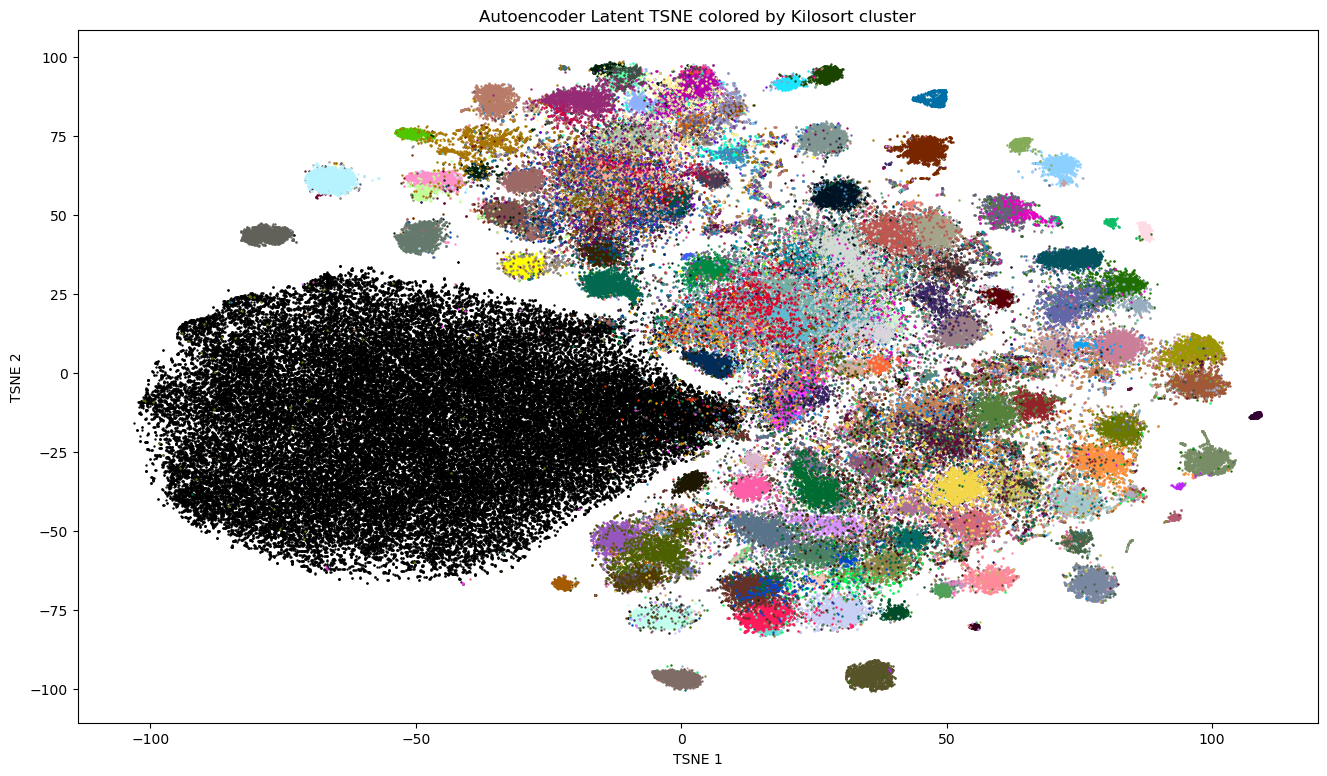

In [127]:
plt.figure(figsize=(16,9))
ind = 0
for group in ae_df.groupby('cl'):
    plt.scatter(group[1]['tsne_1'],group[1]['tsne_2'], s=0.5, label=ind, color=colors[ind]); 
    ind += 1
    
plt.xlabel("TSNE 1"); plt.ylabel("TSNE 2"); plt.title("Autoencoder Latent TSNE colored by Kilosort cluster")

In [131]:
train_all = DataLoader(train_split, batch_size=len(train_loader.dataset), shuffle=True)
for batch in train_all:
    train_data, pca_lab = batch

In [132]:
train_data = train_data.squeeze().reshape(-1,320).cpu().detach().numpy()

In [133]:
pca = PCA(n_components=15)
pca_feat = pca.fit_transform(train_data)

tsne_pca = TSNE(n_components = 2)
pca_tsne = tsne_pca.fit_transform(pca_feat)

KeyboardInterrupt: 